## Importing necessary libs

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score

from catboost import CatBoostRegressor

from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns

## Preparing features and labels from pruned dataframe

In [2]:
df = pd.read_csv("pruned_df.csv")

Xs = df.drop("totalrevenue", 1)
ys = df["totalrevenue"]

In [3]:
Xs.head()

,total_count_interstitial_impression,total_count_banner_impression,total_count_rewarded_impression,total_count_level_event,mean_revenue_interstitial_impression,last_time_interstitial_impression,mean_revenue_rewarded_impression,last_time_banner_impression
0,1,6,0,7,0.030000,2.0,0.00,13.0
1,1,2,0,2,0.030000,0.0,0.00,0.0
2,30,118,2,76,0.027517,4076.0,0.04,4078.0
3,25,82,1,60,0.022920,5136.0,0.04,5137.0
4,5,16,0,18,0.030000,2035.0,0.00,2368.0


In [4]:
ys.head()

0    0.032400
1    0.030750
2    1.211006
3    0.881707
4    0.184700
Name: totalrevenue, dtype: float64

## Train-Test Splitting 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.2, random_state=1773)

## Defining the Regressor

I didn't tune the regressor again since that's time consuming for an experimental analysis like this.

In [6]:
clf = CatBoostRegressor(objective="MAPE",
                        task_type="CPU")

## Predicting with K-Fold CV

In [7]:
cv = KFold(n_splits=5, random_state=1773, shuffle=True)

preds_for_subm = []

mae_scores = []
mape_scores = []
feat_imps = []

for fold_id, (train_ix, test_ix) in enumerate(cv.split(X_train, y=y_train)):

    train_X, val_X = X_train.iloc[train_ix], X_train.iloc[test_ix]
    train_y, val_y = y_train.iloc[train_ix], y_train.iloc[test_ix]
    
    clf.fit(train_X, train_y, eval_set=(val_X, val_y), early_stopping_rounds=150, verbose=False)
    yhat = clf.predict(val_X)
    
    mae = abs(val_y - yhat).mean()
    mae_scores.append(mae)
    
    mape = (abs(val_y - yhat)/val_y).mean()
    mape_scores.append(mape)    
    
    yhat_subm = clf.predict(X_test)
    preds_for_subm.append(yhat_subm)
    
    feat_imps.append(clf.get_feature_importance())
    
    print('RESULTS >> Fold', fold_id+1, "|| MAE:", np.round(mae,3), "|| MAPE:", np.round(mape,3))

RESULTS >> Fold 1 || MAE: 0.078 || MAPE: 0.246
RESULTS >> Fold 2 || MAE: 0.086 || MAPE: 0.24
RESULTS >> Fold 3 || MAE: 0.084 || MAPE: 0.229
RESULTS >> Fold 4 || MAE: 0.085 || MAPE: 0.203
RESULTS >> Fold 5 || MAE: 0.078 || MAPE: 0.414


### CV Results

In [8]:
mean_mae, std_mae = np.mean(mae_scores), np.std(mae_scores)
print('Mean MAE: %.3f, Standard Deviation: %.3f' % (mean_mae, std_mae))

mean_mape, std_mape = np.mean(mape_scores), np.std(mape_scores)
print('Mean MAPE: %.3f, Standard Deviation: %.3f' % (mean_mape, std_mape))

Mean MAE: 0.082, Standard Deviation: 0.004
Mean MAPE: 0.267, Standard Deviation: 0.075


# Test Set Scores

In [9]:
preds_for_subm_arr = np.array(preds_for_subm)
preds_for_subm_arr = preds_for_subm_arr.mean(axis=0)

In [10]:
print("Test MAE:", np.round(abs(y_test - preds_for_subm_arr).mean(),3))
print("Test MAPE:", np.round((abs(y_test - preds_for_subm_arr)/y_test).mean(),3))
print()
print("Test MAE-std:", np.round(abs(y_test - preds_for_subm_arr).std(),3))
print("Test MAPE-std:", np.round((abs(y_test - preds_for_subm_arr)/y_test).std(),3))

Test MAE: 0.082
Test MAPE: 0.203

Test MAE-std: 0.172
Test MAPE-std: 0.557


## Feature Importances

In [11]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' Feature Importances')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Name')

In [12]:
feat_imps = np.array(feat_imps)
mean_feat_imps = feat_imps.mean(axis=0)

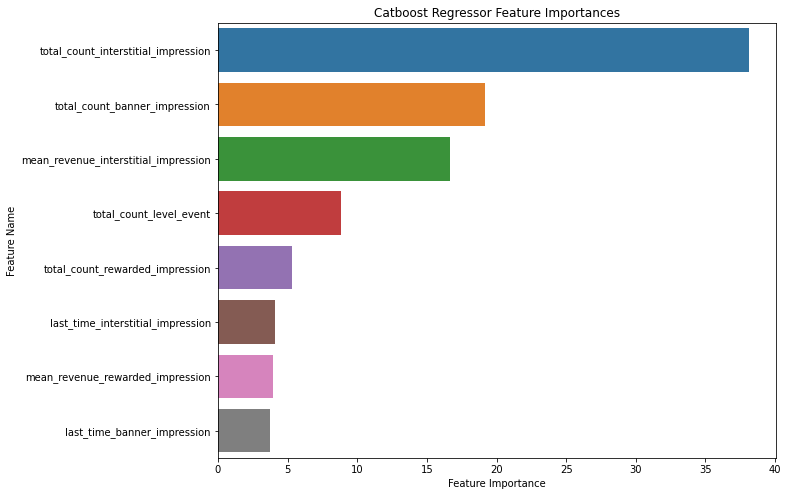

In [13]:
plot_feature_importance(mean_feat_imps,X_train.columns,'Catboost Regressor')

## Brief looking at the predictions

In [14]:
results = np.round(np.vstack([preds_for_subm_arr,y_test]),4)
results_df = pd.DataFrame(columns=["Prediction", "Truth"], data=results.T, index=range(len(results[0])))

results_df.to_csv('predictions.csv', index=False) 

In [15]:
results_df[:50]

,Prediction,Truth
0,1.1491,1.0003
1,0.3365,0.5203
2,0.3127,0.8795
3,0.3313,0.4051
4,0.1322,0.3196
5,0.0511,0.0901
6,0.0310,0.0308
7,0.4606,0.4084
8,0.0868,0.2266
9,0.2504,0.2425
